---
title: Sparse Observations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, SWOT
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
# Ensure TF does not see GPU and grab all GPU memory.
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Sparse Observations

In the previous examples, we were demonstrating how NerFs perform when we have some clean simulation. 
However, in many real problems, we do not have access to such clean

For this example, we are going to look at the case when we have very sparse observations: as in the case with satellite altimetry data like SWOT. In this case

In [2]:
# !wget -nc "https://s3.us-east-1.wasabisys.com/melody/osse_data/data/gridded_data_swot_wocorr/dataset_nadir_0d_swot.nc"

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/dataset_nadir_0d_swot.nc").is_file()

True

In [5]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])

files = [
    # "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/work_eman/ml_ready/swot1nadir5.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/work_eman/ml_ready/nadir4.nc",
]

@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    paths: List[str] = field(default_factory=lambda : files)
    batch_size: int = 5_000
    shuffle: bool = True
    train_size: float = 0.90
    # subset_size: float = None
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["ssh_obs"])
    
# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])


In [6]:
# select = {"time": slice("2012-10-22", "2012-11-22")}
select = {"time": slice("2012-10-01", "2012-12-02")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms,
)

dm.setup()


init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


(-0.967476650713305,
 0.9292991278019631,
 (32, 3),
 -0.9312114076260869,
 0.9810751311573163,
 (32, 1))

In [7]:
len(dm.ds_train)

30946

In [8]:
xrda_obs = dm.load_xrds()

In [9]:
# fig, ax = plt.subplots(ncols=1, figsize=(5,4))

# xrda_obs.ssh_obs.isel(time=1).plot.pcolormesh(ax=ax, cmap="viridis")
# ax.set(title="Original")

# plt.tight_layout()
# plt.show()

In [10]:
# import geoviews as gv
# import geoviews.feature as gf
# from cartopy import crs

# gv.extension('bokeh', 'matplotlib')

In [11]:
# xrda_obs

In [12]:
# dataset = gv.Dataset(xrda_obs)
# ensemble1 = dataset.to(gv.Image, ['lon', 'lat'], "ssh_obs")
# gv.output(ensemble1.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')

In [13]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [14]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [15]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### SIREN Layer

$$
\boldsymbol{\phi}^{(\ell)}(\mathbf{x}) = \sin
\left(
\omega^{(\ell)}\left(
\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} + \mathbf{s}^{(\ell)}
\right)\right)
$$

where $\mathbf{s}$ is the modulation

$$
\mathbf{s}^{(\ell)} = \mathbf{w}_z^{(\ell)}\mathbf{z} + \mathbf{b}_z^{(\ell)}
$$

In [16]:
from jejeqx._src.nets.nerfs.ffn import RFFLayer

model_name = "rff"


model = eqx.nn.Sequential(
    [RFFLayer(in_dim=4, num_features=256, out_dim=256, key=jrandom.PRNGKey(42)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(123)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(23)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(81)),
     RFFLayer(in_dim=256, num_features=256, out_dim=1, key=jrandom.PRNGKey(32)),
    ]
)
# check output of models
out = jax.vmap(model)(jnp.hstack([x_init,t_init]))

assert out.shape == y_init.shape

In [17]:
model_name = "siren"

@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123
    

@dataclass
class SirenBasis:
    _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
    in_size: int = 4
    out_size: int = 256
    width_size: int = 256
    depth: int = 5
    key: Key = Key()
    
@dataclass
class LinearModel:
    _target_: str = "equinox.nn.Linear"
    in_features: int = 256
    out_features: int = 1
    use_bias: bool = True
    key: Key = Key()
    
@dataclass
class NerFModel:
    _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
    # basis_net: RFFBasis = RFFBasis()
    basis_net: SirenBasis = SirenBasis()
    network: LinearModel = LinearModel()
    
# initialize model
model_config = OmegaConf.structured(NerFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(jnp.hstack([x_init,t_init]))

assert out.shape == y_init.shape

In [18]:
# model

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [19]:
import optax

num_epochs = 6_000

@dataclass
class Optimizer:
    _target_: str = "optax.adamw"
    learning_rate: float = 1e-5
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_exponential_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = 1e-2
#     warmup_steps: int = 100
#     end_value: float = 1e-5
#     decay_rate: float = 0.1

# FINETUNE!
@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e-2
    warmup_steps: int = 500
    end_value: float = 1e-6
    
scheduler_config = OmegaConf.structured(Scheduler())

In [20]:
optim_config = OmegaConf.structured(Optimizer())

optimizer = hydra.utils.instantiate(optim_config)

# num_steps_per_epoch = len(dm.ds_train)

# scheduler = hydra.utils.instantiate(
#     scheduler_config, 
#     decay_steps=int(num_epochs * num_steps_per_epoch)
# )

# optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

## Trainer Module

In [21]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )
        
    @property
    def model(self):
        return self.state.params

    @property
    def model_batch(self):
        return jax.vmap(self.state.params, in_axes=(0,0))

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            # pred = jax.vmap(model, in_axes=(0,0))(x, t)
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def test_step(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return pred, {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x, t = batch["spatial"], batch["temporal"]
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            return pred

        return train_step, eval_step, test_step, predict_step
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [22]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = True
save_more = True

In [23]:
%%time

out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 2.88 s, sys: 47.8 ms, total: 2.93 s
Wall time: 2.52 s


{'loss': 0.5244882702827454, 'psnr': -0.3027132749557495}

In [24]:


if model_name == "rff":
    trainer.load_model("./checkpoints/checkpoint_model_rff_ssh_nadir.ckpt")
    # trainer.load_model("./checkpoints/checkpoint_model_rff_ssh_swot.ckpt")
    # trainer.load_model("./checkpoints/checkpoint_natl60_model_rff.ckpt")
    # trainer.load_model("./checkpoints/checkpoint_model_rff_ssh_swot_scratch.ckpt")
elif model_name == "siren":
    # trainer.load_model("./checkpoints/checkpoint_model_siren_ssh_swot.ckpt")
    pass

In [25]:
%%time

out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 145 ms, sys: 4.3 ms, total: 149 ms
Wall time: 141 ms


{'loss': 0.5244882702827454, 'psnr': -0.3027132749557495}

In [26]:
%%time

metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 6000 | Loss: 6.548e-05: 100%|██████████| 6000/6000 [24:43<00:00,  4.05it/s]

CPU times: user 24min 8s, sys: 21.3 s, total: 24min 30s
Wall time: 24min 43s


In [27]:
%%time

out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 135 ms, sys: 2.05 ms, total: 137 ms
Wall time: 131 ms


{'loss': 6.994036084506661e-05, 'psnr': 88.75640869140625}

In [28]:
if save_more:
    if model_name == "rff":
        # trainer.save_model("./checkpoints/checkpoint_model_rff_ssh_swot.ckpt")
        trainer.save_model("./checkpoints/checkpoint_model_rff_ssh_nadir.ckpt")
    elif model_name == "siren":
        trainer.save_model("./checkpoints/checkpoint_model_siren_ssh_nadir.ckpt")

## Evaluation

We will predict the whole dataset at the full resolution available for the same time period.

`01-June-2013 :--> 15-June-2013`

In [29]:
from dataclasses import dataclass, field
from typing import List, Dict


@dataclass
class SSHDMEVAL:
    _target_: str = "jejeqx._src.datamodules.coords.EvalCoordDM"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    decode_times: bool = True
    evaluation: bool = True
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["sossheig"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
    resample: str = "1D"

In [30]:
%%time

# select = {"time": slice("2012-10-22", "2012-11-22")}
select = {"time": slice("2012-10-22", "2012-12-02")}

config_dm = OmegaConf.structured(SSHDMEVAL())

dm_eval = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=dm.spatial_transform,
    temporal_transform=dm.temporal_transform
)

dm_eval.setup()

CPU times: user 15.2 s, sys: 2.66 s, total: 17.8 s
Wall time: 48.4 s


/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


In [31]:
print(f"Num Points: {len(dm_eval.ds_test):,}")

Num Points: 945,000


In [32]:
%%time

xrda = dm_eval.load_xrds()

CPU times: user 14.7 s, sys: 2.46 s, total: 17.2 s
Wall time: 22.5 s


In [33]:
%%time

out, metrics = trainer.test_model(dm_eval.test_dataloader())
metrics

CPU times: user 4.37 s, sys: 37.2 ms, total: 4.4 s
Wall time: 4.11 s


{'loss': 0.007876753807067871, 'psnr': 42.28232955932617}

In [34]:
xrda["ssh_rff"] = dm_eval.data_to_df(out).to_xarray().sossheig

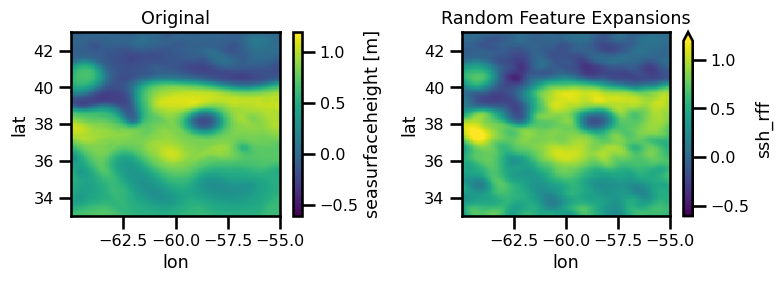

In [35]:
%matplotlib inline

itime = 0

fig, ax = plt.subplots(ncols=2, figsize=(8,3))

vmin = np.min([xrda.sossheig.min(), xrda.ssh_rff.min()])
vmax = np.min([xrda.sossheig.max(), xrda.ssh_rff.max()])

xrda.sossheig.isel(time=itime).plot.pcolormesh(
    ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[0].set(title="Original")

xrda.ssh_rff.isel(time=itime).plot.pcolormesh(
    ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[1].set(title="Random Feature Expansions")

plt.tight_layout()
plt.show()


In [36]:
import common_utils as cutils

In [37]:
ds_rff = cutils.calculate_physical_quantities(xrda.ssh_rff)
ds_natl60 = cutils.calculate_physical_quantities(xrda.sossheig)

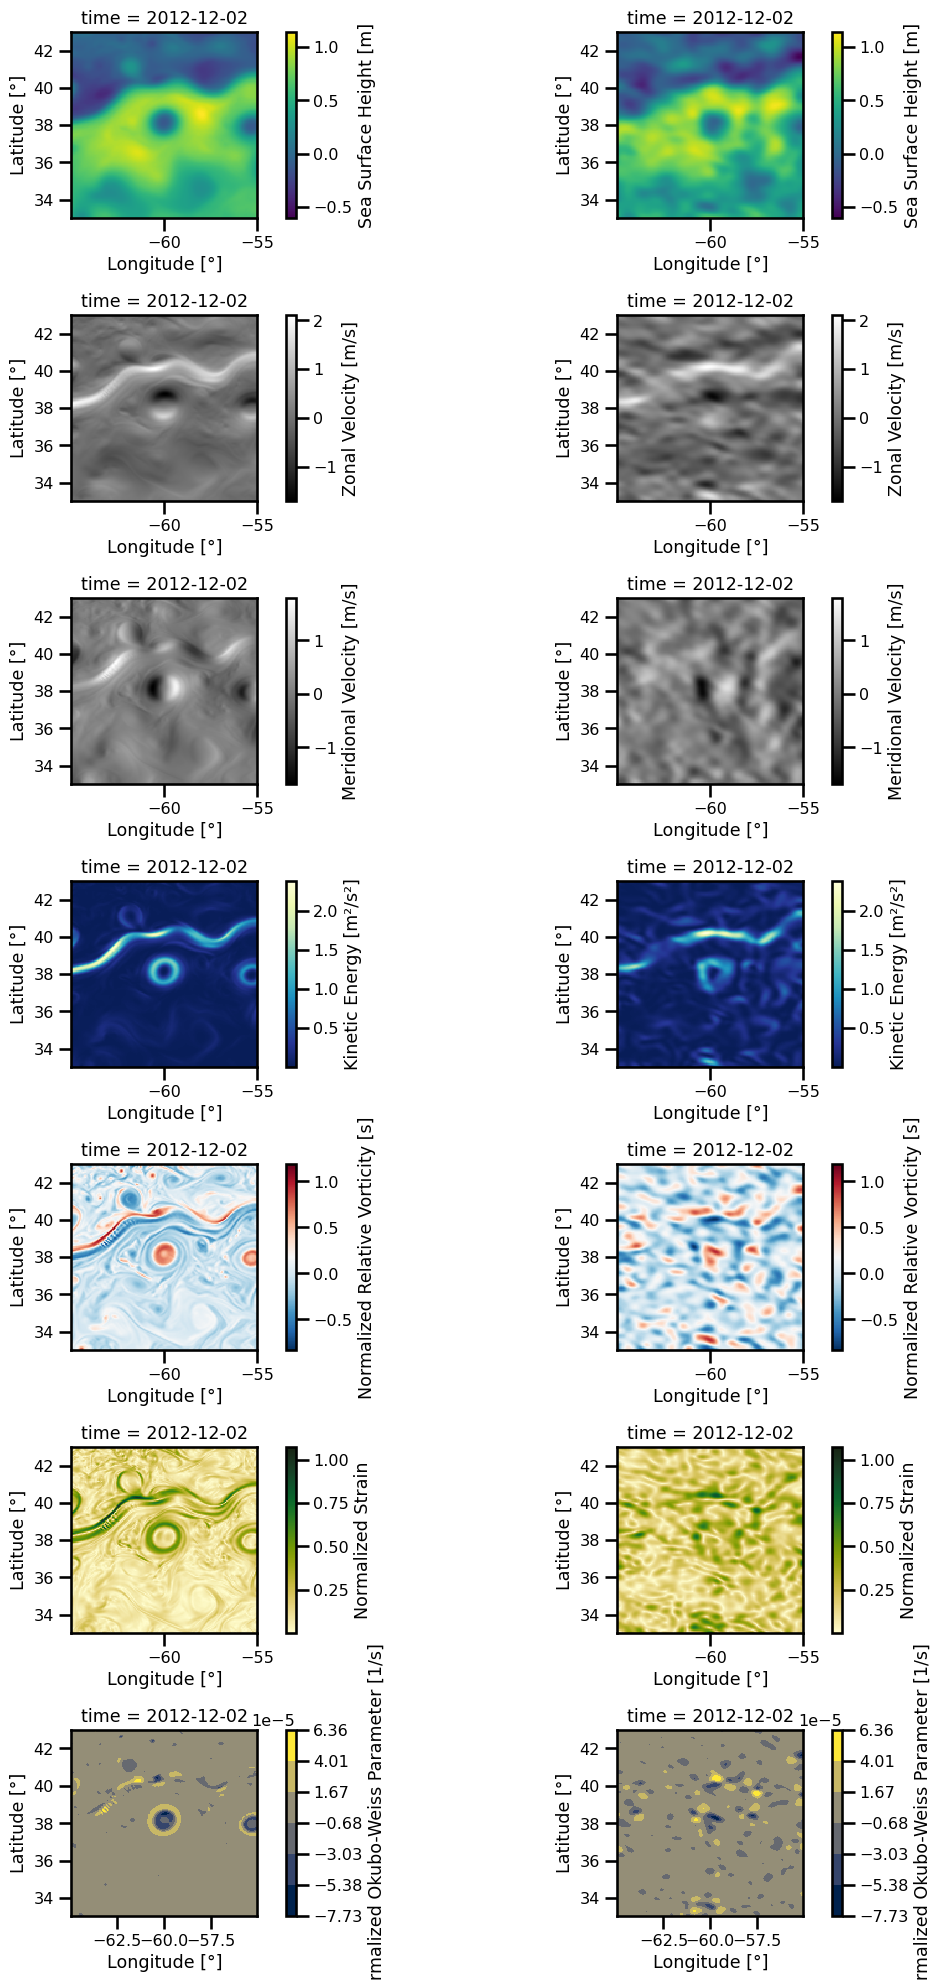

In [38]:
fig, ax = cutils.plot_analysis_vars([
    ds_natl60.isel(time=-1),
    ds_rff.isel(time=-1),]
)
plt.show()

In [41]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rff = cutils.calculate_isotropic_psd(ds_rff)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
fig, ax = cutils.plot_analysis_psd_iso(
    [ds_psd_natl60, ds_psd_rff,],
    ["NATL60","RFE", ]
)
plt.show()

In [ ]:
ds_scores = cutils.calculate_isotropic_psd_score(ds_rff, ds_natl60)

In [ ]:
cutils.plot_analysis_psd_iso_score([ds_scores], ["SGP"], ["k"])
plt.show()

In [120]:
ds_psd_natl60 = cutils.calculate_spacetime_psd(ds_natl60)
ds_psd_rff = cutils.calculate_spacetime_psd(ds_rff)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

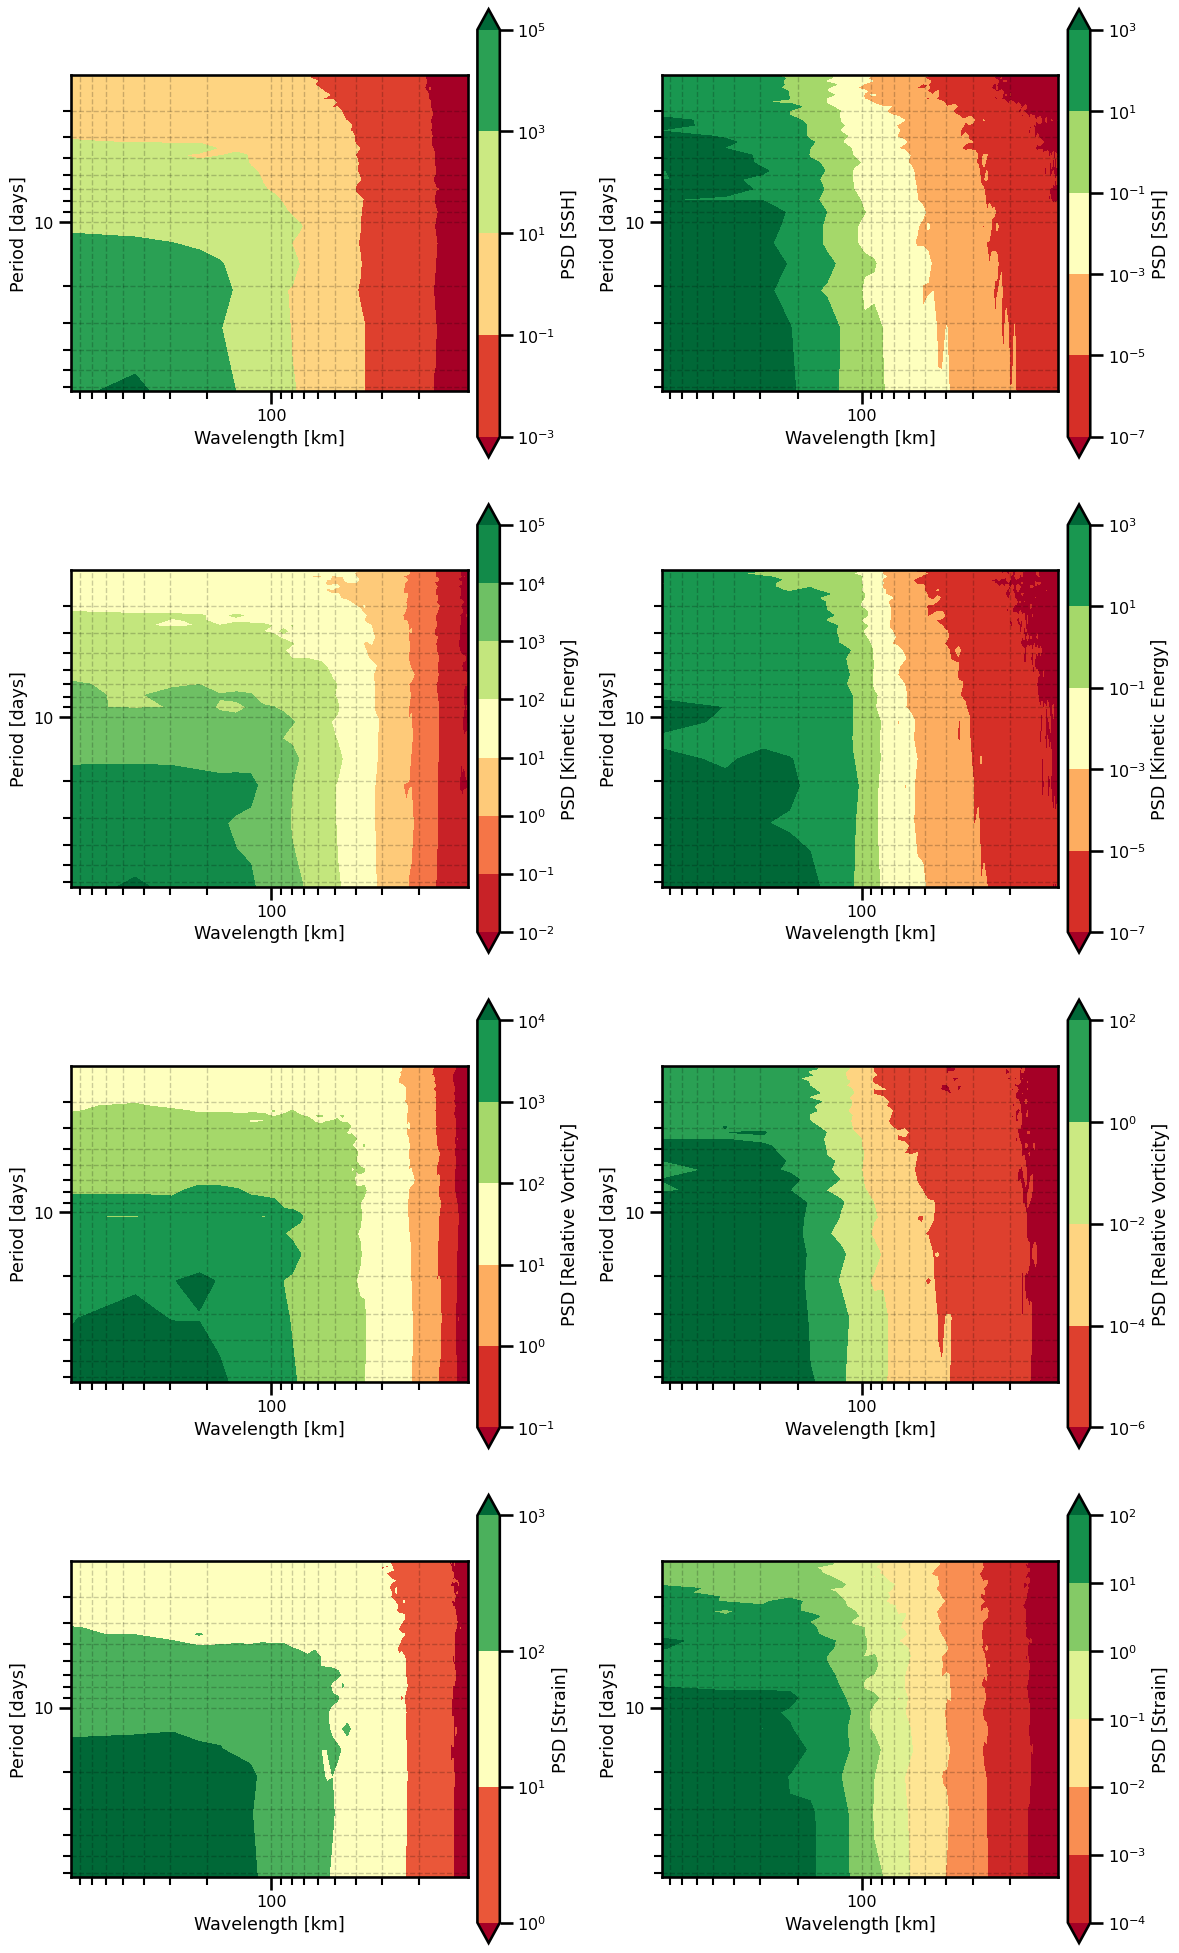

In [121]:
fig, ax = cutils.plot_analysis_psd_spacetime(
    [ds_psd_natl60, ds_psd_rff,],
    ["NATL60","RFE", ]
)
plt.show()

In [122]:
ds_psd_rff = cutils.calculate_spacetime_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

In [127]:
for ivar in ds_psd_rff:
    resolved_spatial_scale = ds_psd_rff[ivar].attrs["resolved_scale_space"] / 1e3 
    print(f"Resolved Scale [km]: {resolved_spatial_scale:.2f} [{ivar.upper()}]")
    resolved_temporal_scale = ds_psd_rff[ivar].attrs["resolved_scale_time"]
    print(f"Resolved Scale [days]: {resolved_temporal_scale:.2f}  [{ivar.upper()}]")

Resolved Scale [km]: 214.25 [SSH]
Resolved Scale [days]: 26.05  [SSH]
Resolved Scale [km]: inf [KE]
Resolved Scale [days]: inf  [KE]
Resolved Scale [km]: inf [VORT_R]
Resolved Scale [days]: inf  [VORT_R]
Resolved Scale [km]: inf [STRAIN]
Resolved Scale [days]: inf  [STRAIN]


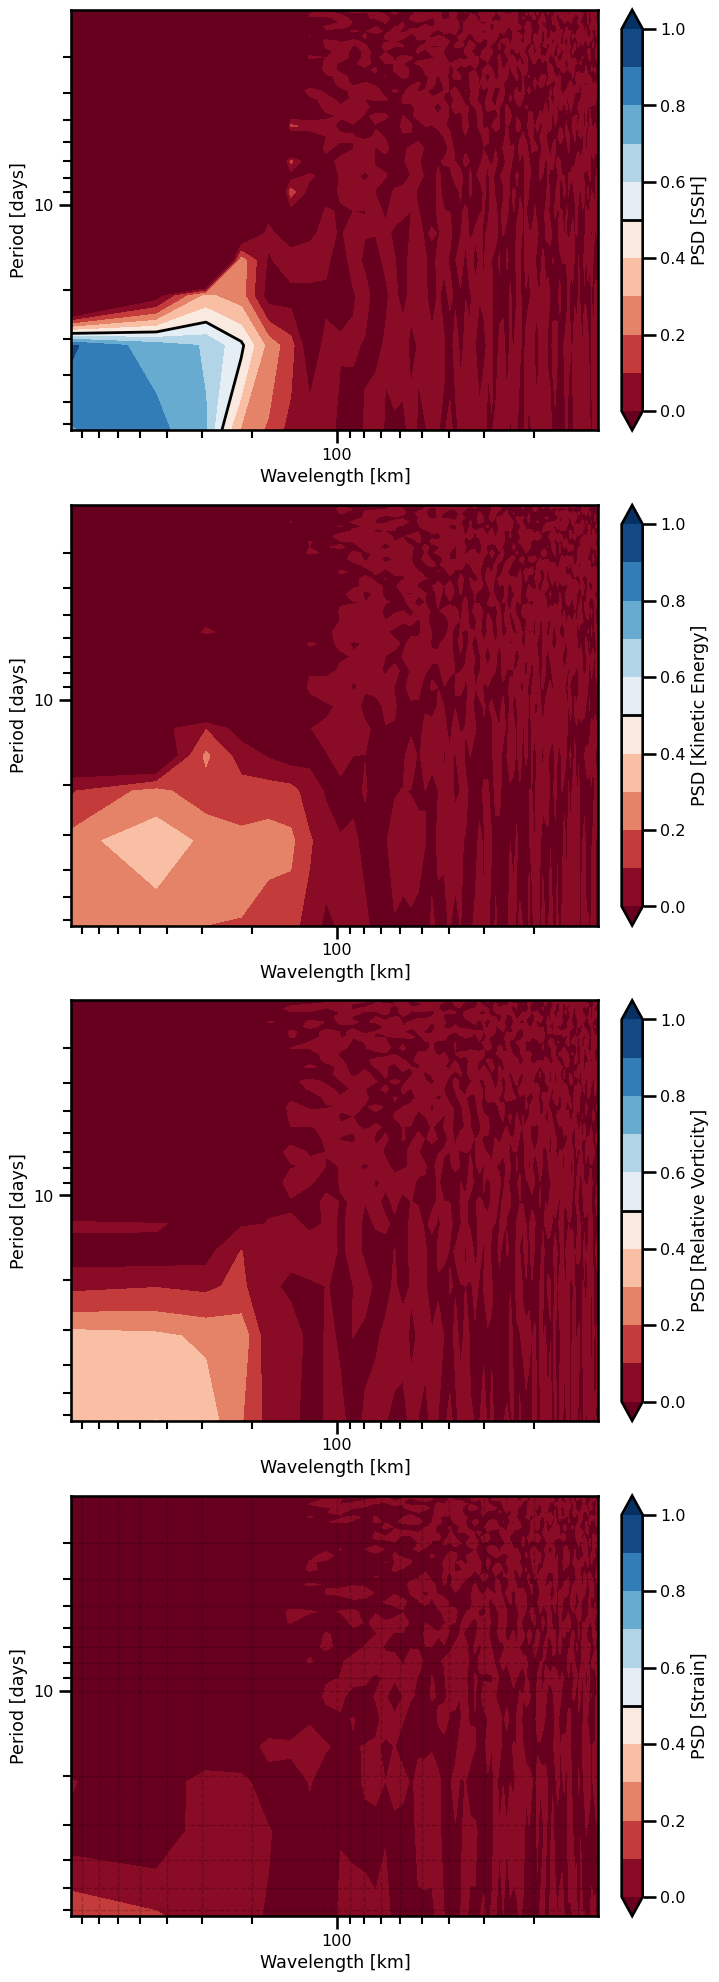

In [124]:
_ = cutils.plot_analysis_psd_spacetime_score(
    [ds_psd_rff], ["rff"]
)